## Simulating and fitting data with VERDICT model

In [123]:
# load the necessary modules
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel, MultiCompartmentSphericalHarmonicsModel



In [124]:
sphere = sphere_models.S4SphereGaussianPhaseApproximation(diffusion_constant=1.2e-9)
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()

verdict_mod = MultiCompartmentModel(models=[sphere, ball, stick])
verdict_mod.parameter_names

verdict_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 2e-9) #2
verdict_mod.set_parameter_optimization_bounds('C1Stick_1_lambda_par', [3.05e-9, 10e-9])

verdict_mod_SH = MultiCompartmentSphericalHarmonicsModel(models=[sphere,ball,stick])

verdict_mod_SH.set_fixed_parameter('G1Ball_1_lambda_iso', 2e-9) #2
verdict_mod_SH.set_parameter_optimization_bounds('C1Stick_1_lambda_par', [3.05e-9, 10e-9])


In [141]:
from dmipy.core.acquisition_scheme import acquisition_scheme_from_schemefile
from os.path import join


acquisition_path_GS55 = "/Users/theavage/Documents/Master/Data/GS55 - long acquisition"

acquisition_path_GS35 = "/Users/theavage/Documents/Master/Data/GS35"

GS35 = "Verdict_brain_5shell_mag2.scheme"

scheme = acquisition_scheme_from_schemefile(join(acquisition_path_GS35, GS35))
long_scheme= acquisition_scheme_from_schemefile(join(acquisition_path_GS55,"GS55_long_protocol2.scheme"))


In [295]:
import dipy
from numpy import reshape
data = dipy.data.fetcher.load_nifti_data(join(acquisition_path_GS55,"GS55_all.nii.gz"))
mask = dipy.data.fetcher.load_nifti_data(join(acquisition_path_GS35,"P35_mask.nii"))



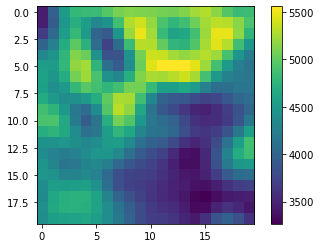

In [309]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
test_voxels=data[80:100,70:90,8,:]

fig, ax = plt.subplots(1)

image = ax.imshow(test_voxels[:,:,0].T)
fig.colorbar(image,ax=ax)

In [310]:
verdict_fit = verdict_mod.fit(long_scheme, test_voxels,solver='mix', use_parallel_processing=True)

Using parallel processing with 4 workers.
Setup MIX optimizer in 0.0002090930938720703 seconds
Fitting of 400 voxels complete in 1060.573222875595 seconds.
Average of 2.6514330571889877 seconds per voxel.


In [405]:
E = verdict_mod.simulate_signal(long_scheme,verdict_fit.fitted_parameters_vector[0,0,:])
verdict_fit.fitted_parameters_vector[0,0,:]

array([ 9.40862620e-06,  8.64802905e-01, -8.41113674e-01,  3.05000000e-09,
        2.44471995e-01,  2.66956002e-01,  4.88572003e-01])

In [418]:
import numpy as np
fake = np.array([[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4]])
sim_signal = verdict_mod.simulate_signal(scheme,fake)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [408]:
E = verdict_fit.predict(long_scheme)

In [355]:
#experimental

verdict_fit.fitted_parameters_vector[0,0]

array([ 9.40862620e-06,  8.64802905e-01, -8.41113674e-01,  3.05000000e-09,
        2.44471995e-01,  2.66956002e-01,  4.88572003e-01])

In [107]:
simulated_fit = verdict_mod.fit(long_scheme, E[0,0,:],solver='mix', use_parallel_processing=True)

Using parallel processing with 4 workers.
Setup MIX optimizer in 0.0003020763397216797 seconds
Fitting of 1 voxels complete in 38.439651012420654 seconds.
Average of 38.439651012420654 seconds per voxel.


In [138]:
print(simulated_fit.fitted_parameters_vector, verdict_fit.fitted_parameters_vector[0,0])

[[1.78907250e-07 9.39865108e-01 8.33170811e-01 3.05000000e-09
  1.43955456e-01 8.56044544e-03 8.47484098e-01]] [1.78907274e-07 9.39865112e-01 2.30842184e+00 3.05000000e-09
 1.43955462e-01 8.56044538e-03 8.47484092e-01]


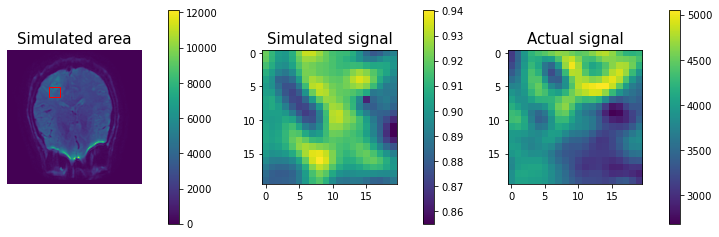

In [390]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
%matplotlib inline

fig, ax = plt.subplots(1,3,constrained_layout=True,figsize=(10,10))

image = ax[0].imshow(data[:, :, 8, 1].T)
fig.colorbar(image,ax=ax[0],shrink=0.3,pad=0.2)
rect = patches.Rectangle((80,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax[0].add_patch(rect)
ax[0].set_axis_off()
ax[0].set_title('Simulated area',style="normal", size=15);

E_img = ax[1].imshow(E[:, :, 1].T)
fig.colorbar(E_img,ax=ax[1],shrink=0.3,pad=0.2)
ax[1].set_title('Simulated signal',size=15);

voxels = ax[2].imshow(test_voxels[:, :, 1].T)
fig.colorbar(voxels,ax=ax[2],shrink=0.3,pad=0.2)
ax[2].set_title('Actual signal',size=15);


Text(0.5, 0.98, 'Fitted parameters in slice z=180 for tumor')

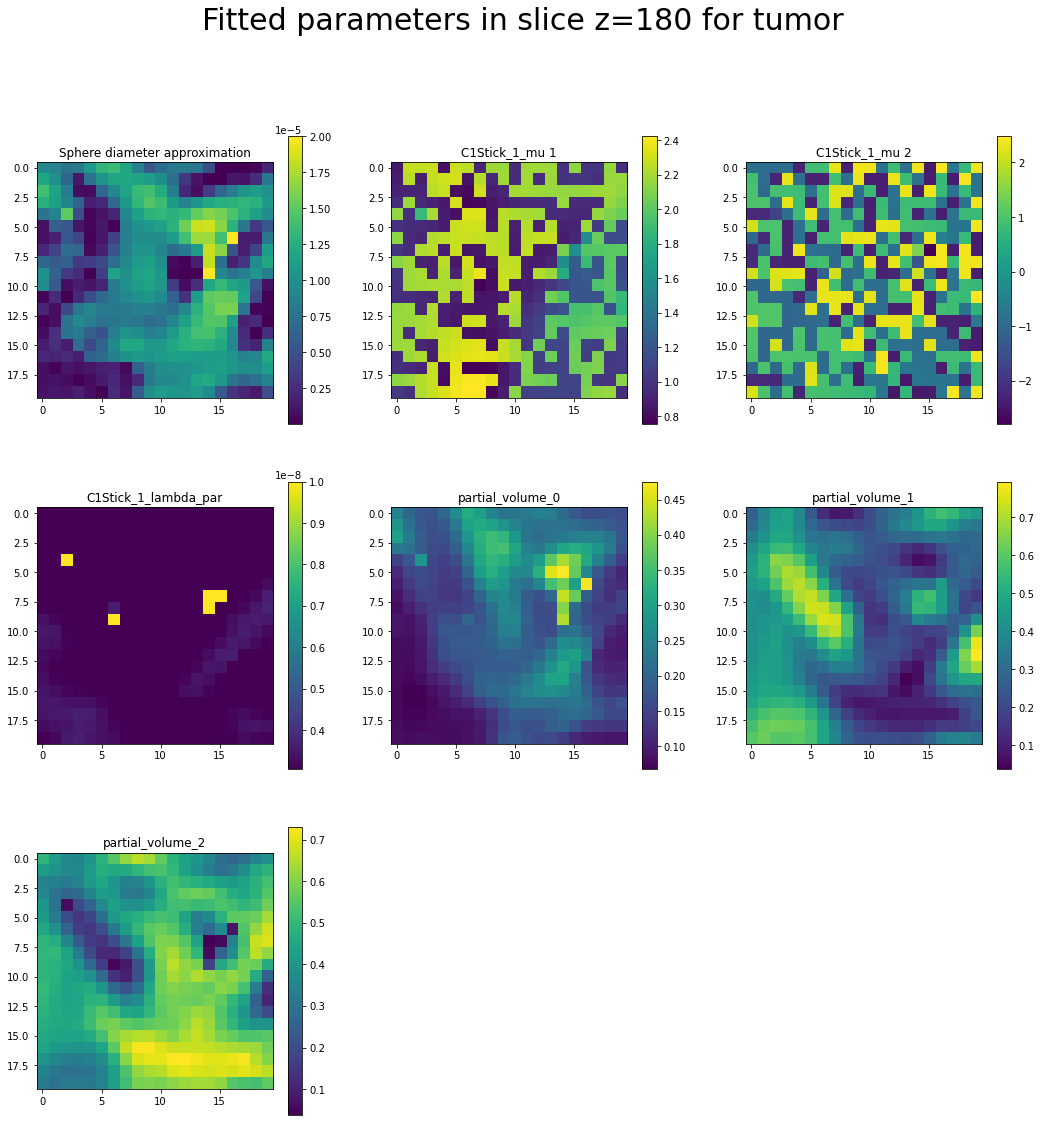

In [382]:
fitted_parameters = verdict_fit.fitted_parameters

fig, axs = plt.subplots(3,3, figsize=[18, 18])
axs = axs.ravel()
fig.delaxes(axs[7])
fig.delaxes(axs[8])

counter=0

#xlim = (150,180)
#ylim = (100,135)
#plt.setp(axs, xlim=xlim, ylim=ylim)

for name, values in fitted_parameters.items():

    if values.squeeze().ndim == 3:
        cf1=axs[counter].imshow(values.squeeze()[:,:,0].T,interpolation='nearest')
        axs[counter].set_title(name+" 1")
        fig.colorbar(cf1, ax=axs[counter])
        counter += 1

        cf2=axs[counter].imshow(values.squeeze()[:,:,1].T,interpolation='nearest')
        axs[counter].set_title(name+" 2")
        fig.colorbar(cf2, ax=axs[counter])

        counter += 1
    else:
        cf = axs[counter].imshow(values.squeeze().T,interpolation='nearest')
        if name == 'S4SphereGaussianPhaseApproximation_1_diameter':
            axs[counter].set_title('Sphere diameter approximation')
        else:
            axs[counter].set_title(name)
        fig.colorbar(cf, ax=axs[counter])
        counter += 1



fig.suptitle('Fitted parameters in slice z=180 for tumor',fontsize=30)
